## **6장 합성곱 신경망 Ⅱ - Part 2**

### 6.1.3 VGGNet

In [ ]:
# 필요한 라이브러리 호출
import copy  # 1
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# 단순한 객체 복사
original = [1, 2, 3] # original이라는 변수에 [1, 2, 3] 저장
copy_o = original # copy_o에 original 복사(shallow copy)
print(copy_o)
copy_o[2] = 10  # copy_o의 3을 10으로 값 변경
print(copy_o)
print(original)

[1, 2, 3]
[1, 2, 10]
[1, 2, 10]


- copy_o뿐만 아니라 원래 값인 original의 3도 10으로 바뀜.

In [ ]:
# 얕은 복사
import copy

original = [[1, 2], 3]
copy_o = copy.copy(original)  # original 값을 copy_o에 얕은 복사(copy.copy())
print(copy_o)
copy_o[0] = 100  # copy_o의 [1, 2] 값을 100으로 변경
print(copy_o)
print(original)

append = copy.copy(original)
append[0].append(4)  # 첫 번째 리스트([1, 2])에 4를 추가
print(append)
print(original)

[[1, 2], 3]
[100, 3]
[[1, 2], 3]
[[1, 2, 4], 3]
[[1, 2, 4], 3]


- copy_o에서 [1, 2] 값을 100으로 변경했더니 copy_o만 바뀜.
- [1, 2]에 4를 추가했더니 original과 copy_o 모두 반영됨.

In [ ]:
# 깊은 복사
import copy

original = [[1, 2], 3]
copy_o = copy.deepcopy(original)  # original 값을 copy_o에 깊은 복사(copy.deepcopy())
print(copy_o)
copy_o[0] = 100 # copy_o의 [1, 2] 값을 100으로 변경
print(copy_o)
print(original)

append = copy.deepcopy(original)
append[0].append(4)  # 첫 번째 리스트([1, 2])에 4를 추가
print(append)
print(original)

[[1, 2], 3]
[100, 3]
[[1, 2], 3]
[[1, 2, 4], 3]
[[1, 2], 3]


- copy_o에서 [1, 2] 값을 100으로 변경했더니 copy_o만 바뀐 것은 동일.
- [1, 2[에 4를 추가했더니 copy_o는 변경되었지만, original은 그대로인 것 확인 가능.

In [ ]:
# VGG 모델 정의
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()
        self.features = features # VGG 모델에 대한 매개변수에서 받아 온 features 값을 넣어 줌.
        self.avgpool = nn.AdaptiveAvgPool2d(7)
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim)
        )  # 완전연결층과 출력층 정의

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [ ]:
# 모델 유형 정의
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
# 8(합성곱층)+3(풀링층)=11(전체 계층) = VGG11
vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
# 10(합성곱층)+3(풀링층)=13(전체 계층) = VGG13
vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M',
                512, 512, 512, 'M']
# 13(합성곱층)+3(풀링층)=16(전체 계층) = VGG16
vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512,
                'M', 512, 512, 512, 512, 'M']
# 16(합성곱층)+3(풀링층)=19(전체 계층) = VGG19

In [ ]:
# VGG 계층 정의
def get_vgg_layers(config, batch_norm):
    layers = []
    in_channels = 3

    for c in config:  # vgg11_config 값들을 가져옴.
        assert c == 'M' or isinstance(c, int)  # 1
        if c == 'M' : # 불러온 값이 'M'이면 최대 출링(MaxPool2d)을 적용
            layers += [nn.MaxPool2d(kernel_size=2)]
        else: # 불러온 값이 숫자면 합성곱(Conv2d) 적용
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm: # 배치 정규화(batch normalization)를 적용할지에 대한 코드
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
                # 배치 정규화 적용될 경우 배치 정규화+ReLU 적용
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
                # 배치 정규화가 적용되지 않을 경우 ReLU만 적용
            in_channels = c
    return nn.Sequential(*layers)  # 네트워크 모든 계층을 반환

In [ ]:
# 모델 계층 생성
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm=True)  # 1

In [ ]:
# VGG11 계층 확인
print(vgg11_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [ ]:
# VGG11 전체에 대한 네트워크
OUTPUT_DIM = 2  # 개와 고양이 두 개의 클래스 사용
model = VGG(vgg11_layers, OUTPUT_DIM)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
# VGG11 사전 훈련된 모델 사용
import torchvision.models as models

pretrained_model = models.vgg11_bn(pretrained=True)  # 1
print(pretrained_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:05<00:00, 105MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
# 이미지 데이터 전처리
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # 1
])
test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # chap06/data/catanddog.zip 데이터 불러오기

Saving catanddog.zip to catanddog.zip


In [ ]:
!unzip catanddog.zip    # 압축 풀기
!unzip catanddog.zip -d catanddog/  # catanddog 폴더 만들어 압축 풀기

Archive:  catanddog.zip
   creating: test/
   creating: test/Cat/
  inflating: test/Cat/8104.jpg       
  inflating: test/Cat/8105.jpg       
  inflating: test/Cat/8106.jpg       
  inflating: test/Cat/cat.12426.jpg  
  inflating: test/Cat/cat.12495.jpg  
  inflating: test/Cat/cat.12496.jpg  
   creating: test/Dog/
  inflating: test/Dog/dog.116.jpg    
  inflating: test/Dog/dog.212.jpg    
  inflating: test/Dog/dog.213.jpg    
  inflating: test/Dog/dog.214.jpg    
  inflating: test/Dog/dog.215.jpg    
  inflating: test/Dog/dog.224.jpg    
   creating: train/
   creating: train/Cat/
  inflating: train/Cat/0.jpg         
  inflating: train/Cat/1.jpg         
  inflating: train/Cat/10.jpg        
  inflating: train/Cat/11.jpg        
  inflating: train/Cat/12.jpg        
  inflating: train/Cat/13.jpg        
  inflating: train/Cat/14.jpg        
  inflating: train/Cat/15.jpg        
  inflating: train/Cat/16.jpg        
  inflating: train/Cat/17.jpg        
  inflating: train/Cat/18.jpg  

In [ ]:
# ImageFolder를 이용하여 데이터셋 불러오기
train_path = 'catanddog/train'
test_path = 'catanddog/test'

train_dataset = torchvision.datasets.ImageFolder(
    train_path,
    transform=train_transforms)  # 1

test_dataset = torchvision.datasets.ImageFolder(
    test_path,
    transform=test_transforms)

print(len(train_dataset)), print(len(test_dataset))

529
12


(None, None)

In [ ]:
# 훈련과 검증 데이터 분할
VALID_RATIO = 0.9
n_train_examples = int(len(train_dataset) * VALID_RATIO)
# 전체 훈련 데이터 중 90%를 훈련 데이터셋으로 사용
n_valid_examples = len(train_dataset) - n_train_examples
# 전체 훈련 데이터 중 10%를 검증 데이터셋으로 사용
train_data, valid_data = data.random_split(train_dataset,
                                           [n_train_examples, n_valid_examples]) # 1

In [ ]:
# 검증 데이터 전처리
valid_data = copy.deepcopy(valid_data)
valid_data.dataset_transform = test_transforms

In [ ]:
# 훈련, 검증, 테스트 데이터셋 수 확인
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_dataset)}')

Number of training examples: 476
Number of validation examples: 53
Number of testing examples: 12


In [ ]:
# 메모리로 데이터 불러오기
BATCH_SIZE = 32  # 메모리 부족 오류로 배치 사이즈 줄이기
train_iterator = data.DataLoader(train_data,
                                 shuffle=True, # 훈련 데이터셋은 임의로 섞어서 가져옴.
                                 batch_size=BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_dataset,
                                batch_size=BATCH_SIZE)

In [ ]:
# 옵티마이저와 손실 함수 정의
optimizer = optim.Adam(model.parameters(), lr = 1e-7)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
# 모델 정확도 측정 함수
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()  # 1
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
# 모델 학습 함수 정의
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred, _ = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
# 모델 성능 측정 함수
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
# 학습 시간 측정 함수
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import time

In [ ]:
# 모델 학습
EPOCHS = 5
best_valid_loss = float('inf')
for epoch in range(EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    # 훈련 데이터셋을 모델에 적용한 결과(오차와 정확도)를 train_loss, train_acc에 저장
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    # 검증 데이터셋을 모델에 적용한 결과(오차와 정확도)를 valid_loss와 valid_acc에 저장

    if valid_loss < best_valid_loss: # valid_loss가 가장 작은 값을 구하고 그 상태의 모델을 VGG-model.pt 이름으로 저장
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'VGG-model.pt')

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    # 모델 훈련에 대한 시작과 종료 시간 저장
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss: .3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Valid. Loss: {valid_loss: .3f} |  Valid. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: -28847809m -37s
	Train Loss:  0.697 | Train Acc: 51.28%
	 Valid. Loss:  0.694 |  Valid. Acc: 46.58%
Epoch: 02 | Epoch Time: -28847809m -46s
	Train Loss:  0.692 | Train Acc: 55.30%
	 Valid. Loss:  0.694 |  Valid. Acc: 57.51%
Epoch: 03 | Epoch Time: -28847809m -48s
	Train Loss:  0.692 | Train Acc: 51.34%
	 Valid. Loss:  0.686 |  Valid. Acc: 54.24%
Epoch: 04 | Epoch Time: -28847809m -53s
	Train Loss:  0.695 | Train Acc: 53.01%
	 Valid. Loss:  0.688 |  Valid. Acc: 60.57%
Epoch: 05 | Epoch Time: -28847809m -55s
	Train Loss:  0.688 | Train Acc: 54.82%
	 Valid. Loss:  0.686 |  Valid. Acc: 53.50%


In [ ]:
# 테스트 데이터셋을 이용한 모델 성능 측정
model.load_state_dict(torch.load('VGG-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss: .3f} | Test Acc: {test_acc*100: .2f}%')

<ipython-input-31-fd64dd12e59e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('VGG-model.pt'))


Test Loss:  0.684 | Test Acc:  50.00%


In [ ]:
# 테스트 데이터셋을 이용한 모델의 예측 확인 함수
def get_predictions(model, iterator):
    model.eval()
    images=[]
    labels=[]
    probs=[]

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim=-1)
            top_pred = y_prob.argmax(1, keepdim=True)  # 1
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())
    images = torch.cat(images, dim=0)  # 2
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)
    return images, labels, probs

In [ ]:
## torch.cat 예제 ##
import torch
x = torch.Tensor([[1, 2, 3], [2, 3, 4]])
y = torch.Tensor([[4, 5, 6], [5, 6, 7]])

print(torch.cat([x], dim=0))  # 행을 기준(dim=0)으로 x를 이어 붙임.
print('-----------------------')
print(torch.cat([x, y]))  # 단순히 x와 y를 결합하라는 의미, 출력 결과는 (4x3) 형태
print('-----------------------')
print(torch.cat([x, y], dim=0))  # 행을 기준(dim=0)으로 x와 y를 이어 붙임, (4x3) 텐서
print('-----------------------')
print(torch.cat([x, y], dim=1))  # 열을 기준(dim=1)으로 x와 y를 이어 붙임, (2x6) 텐서

tensor([[1., 2., 3.],
        [2., 3., 4.]])
-----------------------
tensor([[1., 2., 3.],
        [2., 3., 4.],
        [4., 5., 6.],
        [5., 6., 7.]])
-----------------------
tensor([[1., 2., 3.],
        [2., 3., 4.],
        [4., 5., 6.],
        [5., 6., 7.]])
-----------------------
tensor([[1., 2., 3., 4., 5., 6.],
        [2., 3., 4., 5., 6., 7.]])


In [ ]:
# 예측 중에서 정확하게 예측한 것을 추출
images, labels, probs = get_predictions(model, test_iterator)
pred_labels = torch.argmax(probs, 1)  # 1
corrects = torch.eq(labels, pred_labels)  # 예측과 정답이 같은지 비교
correct_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects): # 2
    if correct:
        correct_examples.append((image, label, prob))

correct_examples.sort(reverse=True, key=lambda x: torch.max(x[2], dim=0).values) # 3

In [ ]:
## 최댓값과 인덱스 예제 ##
x = torch.rand(5, 3)  # (5x3) 형태의 텐서 생성
print(x)

tensor([[0.9753, 0.0613, 0.8958],
        [0.4323, 0.1601, 0.2134],
        [0.4731, 0.4969, 0.4790],
        [0.7351, 0.1033, 0.7055],
        [0.9867, 0.8069, 0.1903]])


In [ ]:
print(torch.max(x))  # max 반환값
print('--------------------')
print(torch.argmax(x))  # argmax 반환값

tensor(0.9867)
--------------------
tensor(12)


In [ ]:
## zip() 예제 ##
a = [1, 2, 3]
b = ['a','b','c']

for x, y in zip(a, b):  # a, b가 리스트로 구성되었기 때문에 for문을 통해 반복하여 값 가져옴.
    print(x, y)

1 a
2 b
3 c


In [ ]:
## 데이터 정렬 예제 ##
x = [1, 7, 3, 9]  # 정렬되어 있지 않은 x 텐서
x.sort(reverse=True)  # x에 내림차순 적용
print('x:', x)

x: [9, 7, 3, 1]


In [ ]:
## 람다 함수 예제 ##
y = lambda x: x+10
y(1)

11

In [ ]:
x = torch.randn([4, 4])  # (4x4) 크기의 임의의 텐서 생성
print(x)

max_elements, max_idxs = torch.max(x, dim=0)  # torch.max 값을 가지고 오되 dim=0(행 기준)으로 최댓값 가져옴.
print(max_elements)
print(max_idxs)

tensor([[ 0.1023,  1.1145,  0.0605,  0.2931],
        [-1.1398,  0.5492,  0.0222,  1.7887],
        [-0.1659, -0.3684, -1.5113, -0.9749],
        [ 0.8112, -0.9238,  0.1286,  0.6145]])
tensor([0.8112, 1.1145, 0.1286, 1.7887])
tensor([3, 0, 3, 1])


In [ ]:
# 이미지 출력을 위한 전처리
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    # torch.clamp : 주어진 최소, 최대의 범주에 이미지가 위치하도록 함.
    image.add_(-image_min).div_(image_max-image_min+1e-5)  # 1
    return image

In [ ]:
## torch.add 예제 ##
x = torch.tensor([1, 2])
y = x.add(10)  # torch.add 적용
print(y)
print(x is y)
print('-------------------')
y = x.add_(10) # torch.add_ 적용
print(y)
print(x is y)

tensor([11, 12])
False
-------------------
tensor([11, 12])
True


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# 모델이 정확하게 예측한 이미지 출력 함수
def plot_most_correct(correct, classes, n_images, normalize=True):
    rows = int(np.sqrt(n_images)) # np.sqrt : 제곱근을 계산(0.5 거듭제곱)
    cols = int(np.sqrt(n_images))
    fig, axes = plt.subplots(rows, cols, figsize=(25, 20))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)  # 출력하려는 그래프 개수만큼 subplot 만들기
        image, true_label, probs = correct[i]
        image = image.permute(1, 2, 0) # 1
        true_prob = probs[true_label]
        correct_prob, correct_label = torch.max(probs, dim=0)
        true_class = classes[true_label]
        correct_class = classes[correct_label]

        if normalize: # 본래 이미지대로 출력 하기 위해 normalize_image 함수 호출
            image = normalize_image(image)
        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob: .3f})\n' \
                     f'pred label: {correct_class} ({correct_prob: .3f})')
        ax.axis('off')

    fig.subplots_adjust(hspace=0.4)

In [ ]:
## image.permute 예제 ##
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(x)
x.permute(1, 0)  # 차원(축) 0과 1을 바꿈.

tensor([[1, 2, 3],
        [4, 5, 6]])


tensor([[1, 4],
        [2, 5],
        [3, 6]])

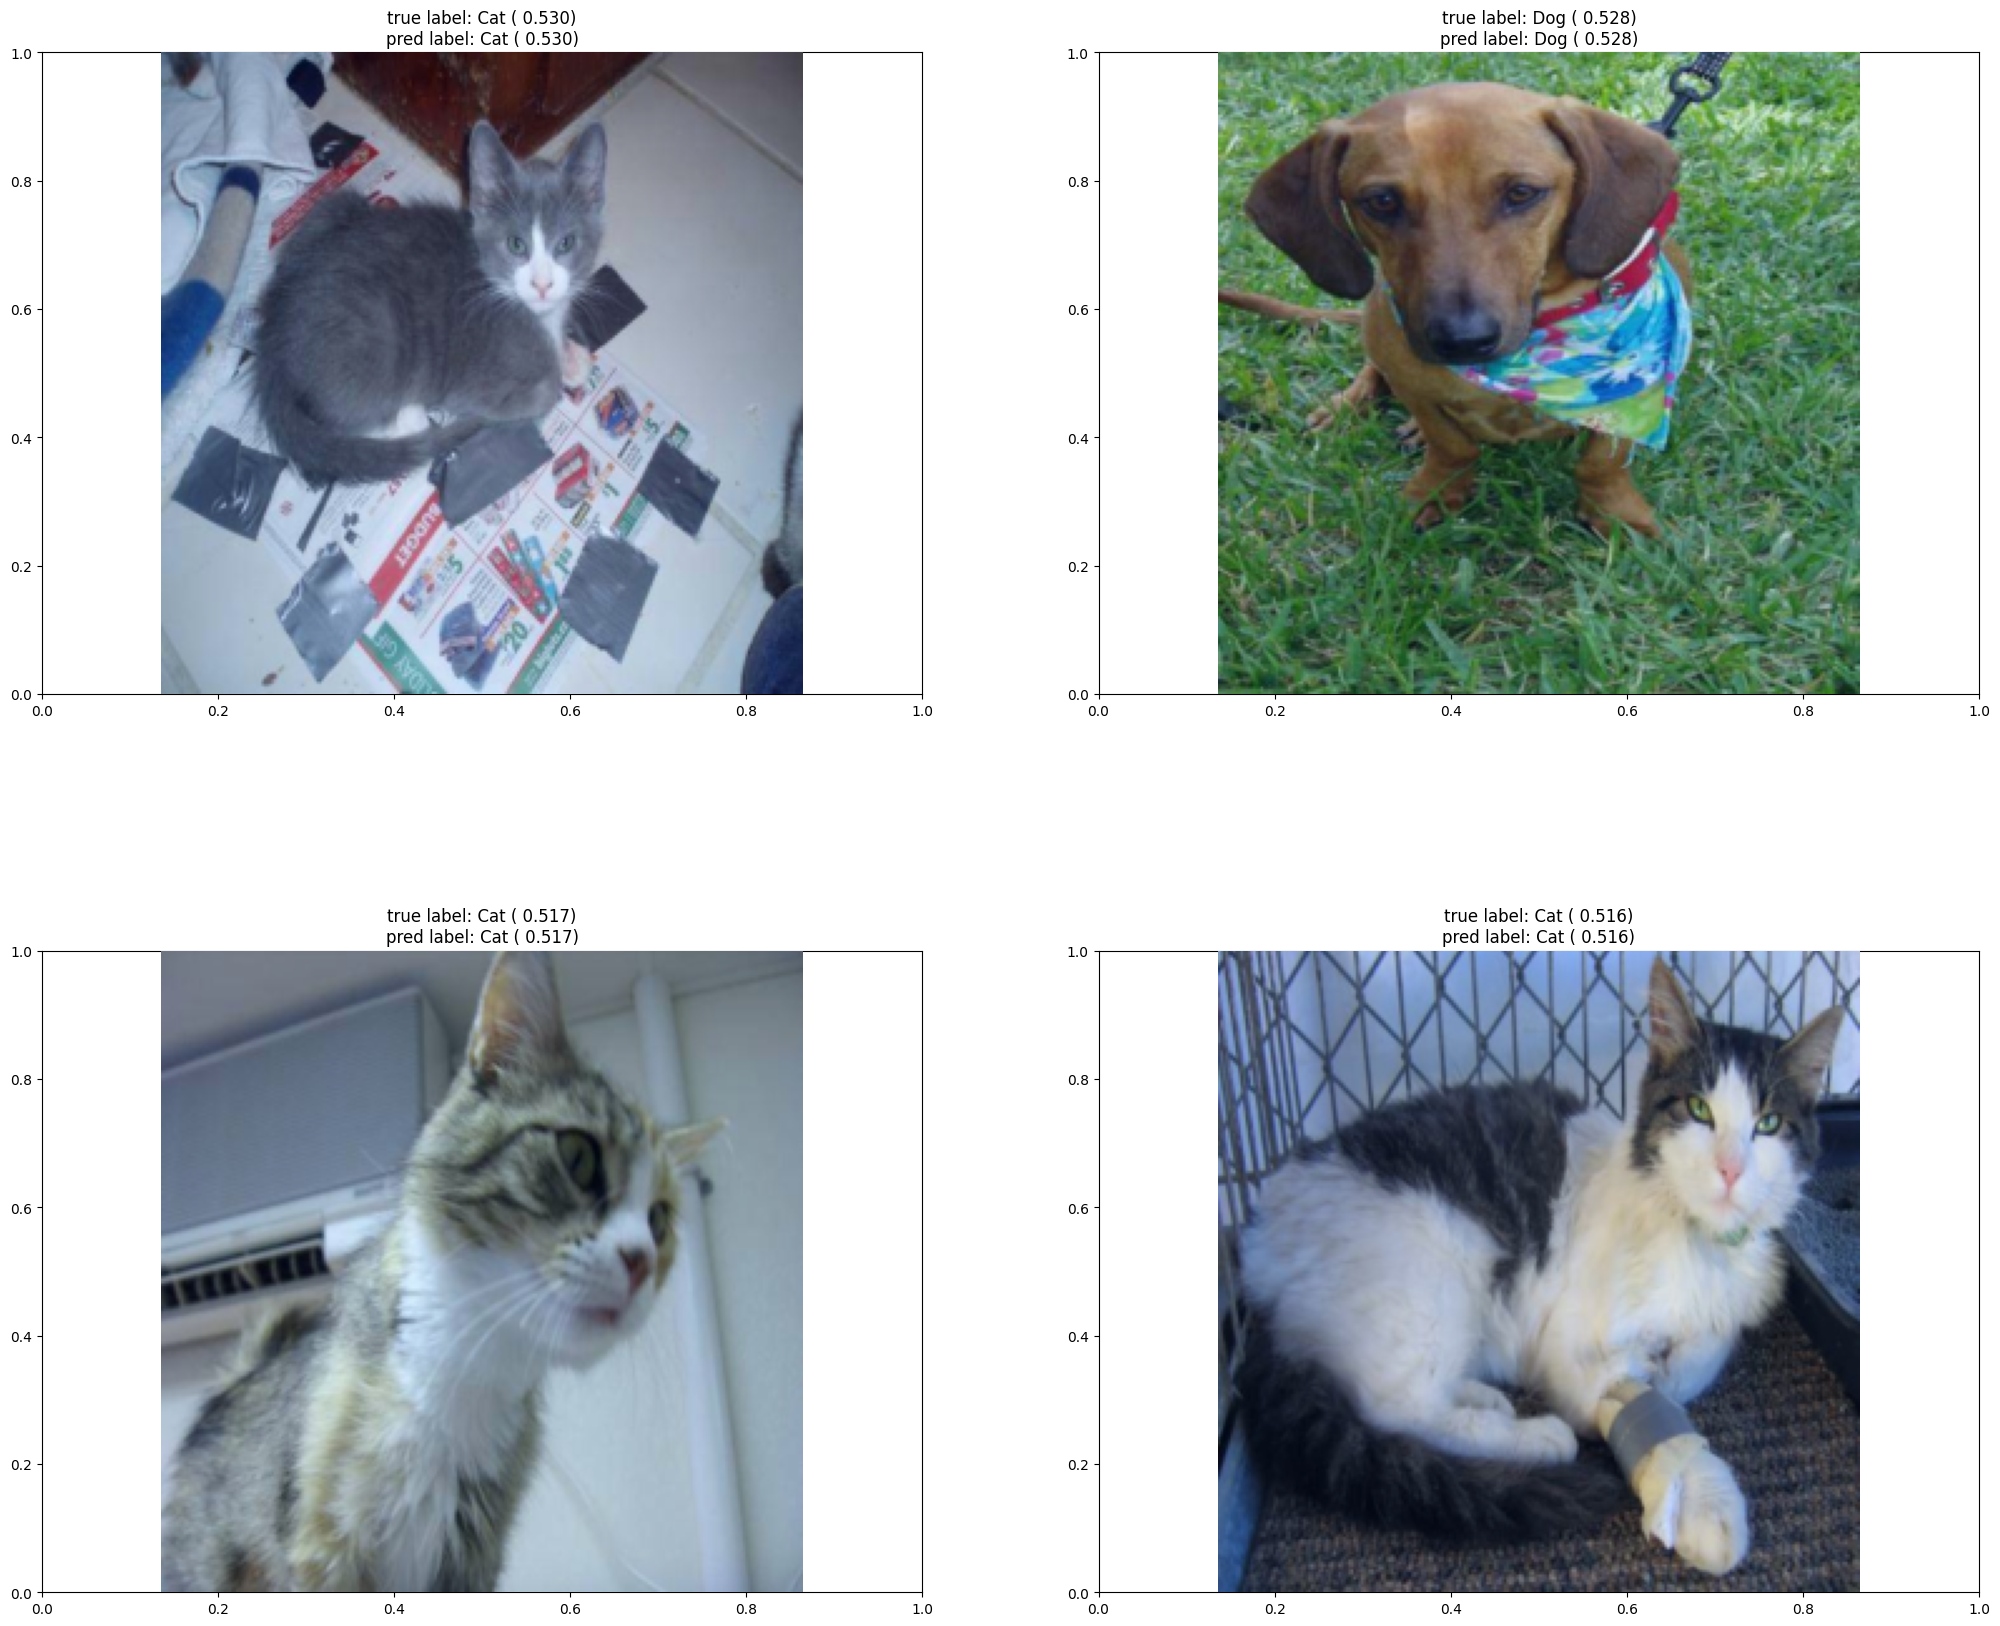

In [ ]:
# 예측 결과 이미지 출력
classes = test_dataset.classes
N_IMAGES = 5
plot_most_correct(correct_examples, classes, N_IMAGES)